In [1]:
import random
import matplotlib.pyplot as plt
import time

amountOfLocations = None
locations = []
cars = None
depot = None 

generations = 50
population_size = 15
mutation_rate = 0.3

In [ ]:
def generate_locations(n, bounds=(0,100), seed=None):
    if seed is not None:
        rnd = random.Random(seed)
        return [(rnd.randint(bounds[0], bounds[1]), rnd.randint(bounds[0], bounds[1])) for _ in range(n)]
    return [(random.randint(bounds[0], bounds[1]), random.randint(bounds[0], bounds[1])) for _ in range(n)]

def make_scenarios(seed=None):
    s = 0 if seed is None else seed
    return [
        {"id":"small-1",  "depot":(50, 50),"num_vehicles":3,  "num_customers":12, "customers": generate_locations(12, seed=s+1)},
        {"id":"small-2",  "depot":(50, 50),"num_vehicles":7,  "num_customers":18, "customers": generate_locations(18, seed=s+2)},
        {"id":"medium-1", "depot":(50, 50),"num_vehicles":11, "num_customers":20, "customers": generate_locations(20, seed=s+3)},
        {"id":"medium-2", "depot":(50, 50),"num_vehicles":15, "num_customers":28, "customers": generate_locations(28, seed=s+4)},
        {"id":"large-1",  "depot":(50, 50),"num_vehicles":26, "num_customers":30, "customers": generate_locations(30, seed=s+5)},
        {"id":"large-2",  "depot":(50, 50),"num_vehicles":30, "num_customers":40, "customers": generate_locations(38, seed=s+6)},
    ]

def applay_scenario(scenario):
    global amountOfLocations, locations, cars, depot
    amountOfLocations = scenario["num_customers"]
    locations = scenario["customers"][:]
    cars = scenario["num_vehicles"]
    depot = scenario.get("depot", (50, 50))



In [3]:
if not locations:
    if amountOfLocations is None:
        amountOfLocations = 50   # fallback default
    locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(amountOfLocations)]

def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_vrp_cost_and_routes(individual, num_vehicles):
    n = len(individual)
    if n == 0:
        return float('inf'), []
    # Precompute distances between consecutive customers
    dist_seq = [distance(locations[individual[i]], locations[individual[(i+1) % n]]) for i in range(n)]
    prefix = [0] * (n + 1)
    for i in range(n):
        prefix[i+1] = prefix[i] + dist_seq[i]
    inf = float('inf')
    dp = [[inf] * (n + 1) for _ in range(num_vehicles + 1)]
    prev = [[-1] * (n + 1) for _ in range(num_vehicles + 1)]
    dp[0][0] = 0
    for m in range(1, num_vehicles + 1):
        for j in range(1, n + 1):
            for i in range(j):
                if j - i < 1:  # No empty routes
                    continue
                internal = prefix[j] - prefix[i]
                start_cust = locations[individual[i]]
                end_cust = locations[individual[j-1]]
                route_cost = distance(depot, start_cust) + internal + distance(end_cust, depot)
                new_cost = dp[m-1][i] + route_cost
                if new_cost < dp[m][j]:
                    dp[m][j] = new_cost
                    prev[m][j] = i
    total_distance = dp[num_vehicles][n]
    if total_distance == inf:
        return inf, []
    # Reconstruct routes
    routes = []
    m = num_vehicles
    j = n
    while j > 0:
        i = prev[m][j]
        if i == -1:
            return inf, []
        route = individual[i:j]
        routes.append(route)
        j = i
        m -= 1
    routes.reverse()
    return total_distance, routes

def fitness(individual):
    total_dist, _ = get_vrp_cost_and_routes(individual, cars)
    return 1 / total_dist if total_dist > 0 else 0

def create_individual():
    return random.sample(range(len(locations)), len(locations))

def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [-1] * len(parent1)
    child[start:end] = parent1[start:end]
    pointer = end
    for location in parent2:
        if location not in child:
            child[pointer] = location
            pointer = (pointer + 1) % len(child)
    return child

def mutate(individual):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def tournament_selection(population, k=3):
    contestants = random.sample(population, k)
    return max(contestants, key=fitness)

def visualize_individual(individual, fitness_value):
    total_dist, routes = get_vrp_cost_and_routes(individual, cars)
    route_str = "\n".join([f"Vehicle {r+1}: depot -> " + " -> ".join(map(str, route)) + " -> depot" for r, route in enumerate(routes)])
    return f"{route_str}\nTotal Distance: {total_dist:.2f} Fitness: {fitness_value:.6f}"

def genetic_algorithm_with_tracking():
    population = [create_individual() for _ in range(population_size)]
    best_fitness_per_gen = []
    elite_size = 1  # Adjust as needed, e.g., int(0.1 * population_size)
    
    for generation in range(generations):
        fitnesses = [fitness(ind) for ind in population]
        best_fitness = max(fitnesses)
        best_fitness_per_gen.append(best_fitness)
        
        # Find elites: Sort population by fitness descending and take top elite_size
        sorted_pop = sorted(population, key=fitness, reverse=True)
        elites = [ind[:] for ind in sorted_pop[:elite_size]]  # Copy to avoid mutation
        
        new_population = []
        # Generate fewer offspring to accommodate elites
        for _ in range((population_size - elite_size) // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        
        # Add elites to new population
        new_population.extend(elites)
        
        population = new_population
    return best_fitness_per_gen


Running scenario: small-1
  Vehicles: 3, Customers: 12
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


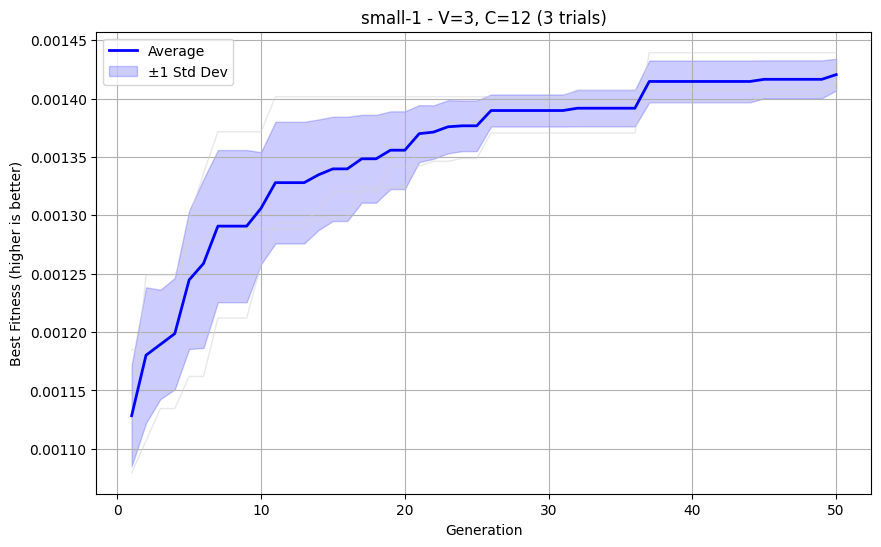

  Best final fitness: 0.001439
  Worst final fitness: 0.001408
  Average final fitness: 0.001420 ± 0.000014

Running scenario: small-2
  Vehicles: 7, Customers: 18
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


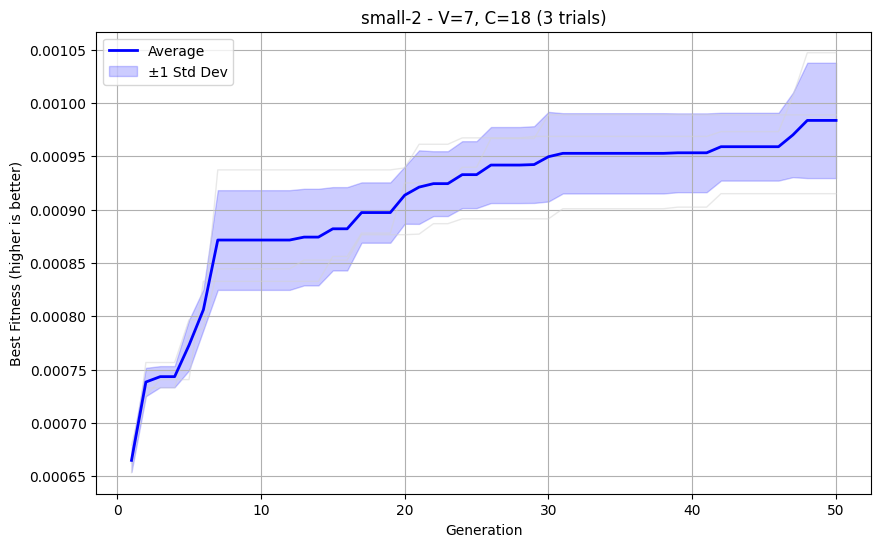

  Best final fitness: 0.001047
  Worst final fitness: 0.000915
  Average final fitness: 0.000984 ± 0.000054

Running scenario: medium-1
  Vehicles: 11, Customers: 20
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


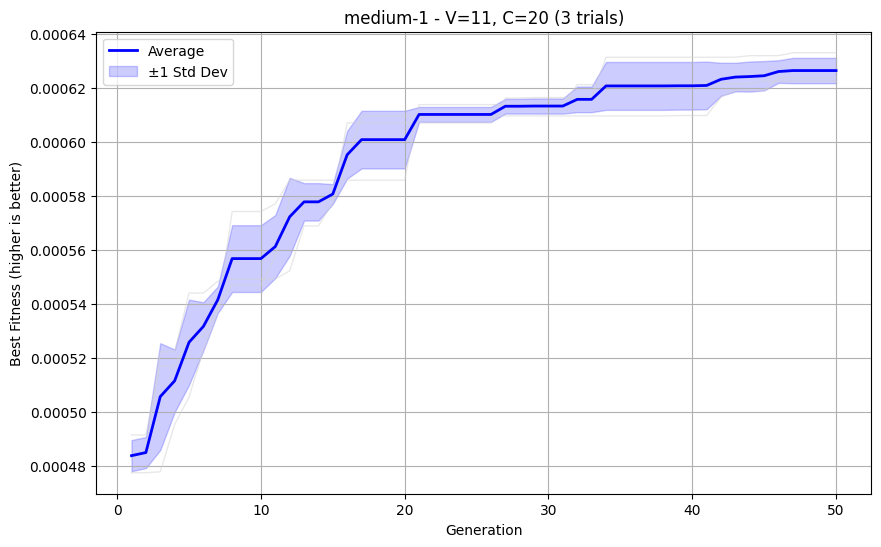

  Best final fitness: 0.000633
  Worst final fitness: 0.000623
  Average final fitness: 0.000626 ± 0.000005

Running scenario: medium-2
  Vehicles: 15, Customers: 28
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


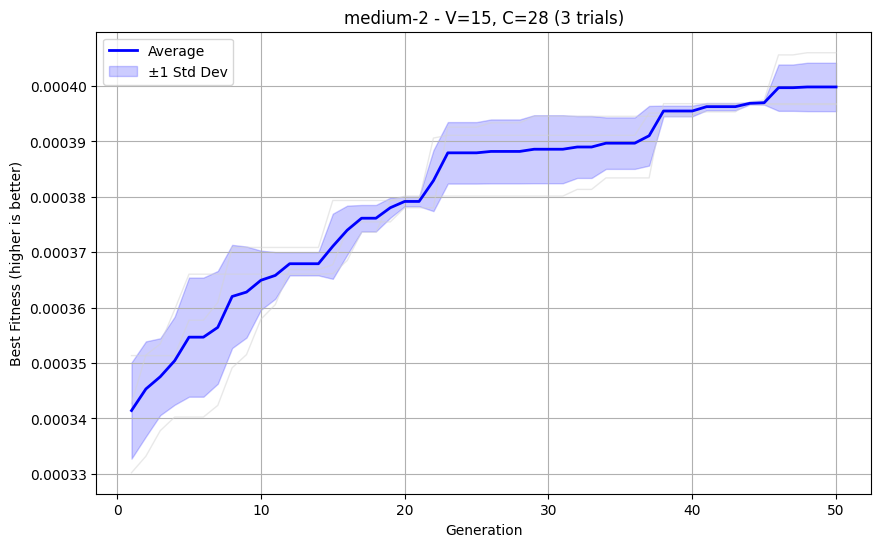

  Best final fitness: 0.000406
  Worst final fitness: 0.000397
  Average final fitness: 0.000400 ± 0.000004

Running scenario: large-1
  Vehicles: 26, Customers: 30
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


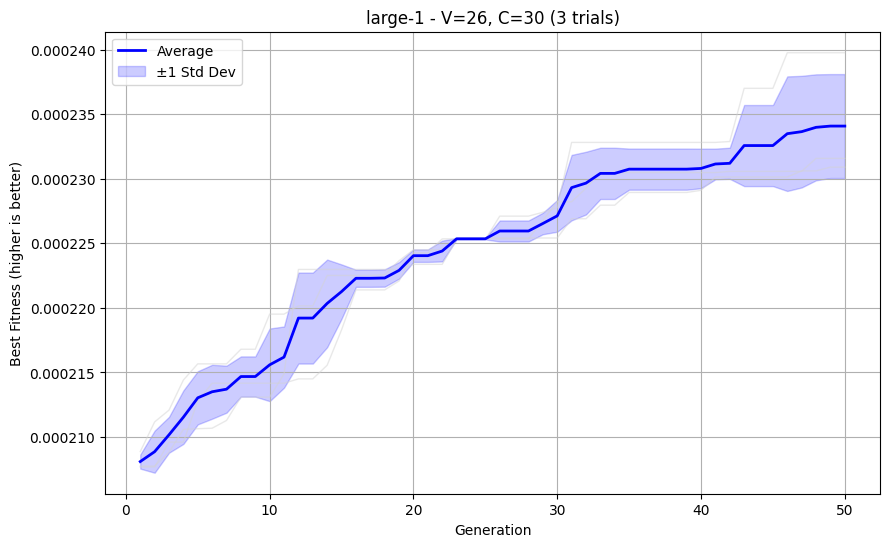

  Best final fitness: 0.000240
  Worst final fitness: 0.000231
  Average final fitness: 0.000234 ± 0.000004

Running scenario: large-2
  Vehicles: 30, Customers: 40
  Trial 1/3...
  Trial 2/3...
  Trial 3/3...


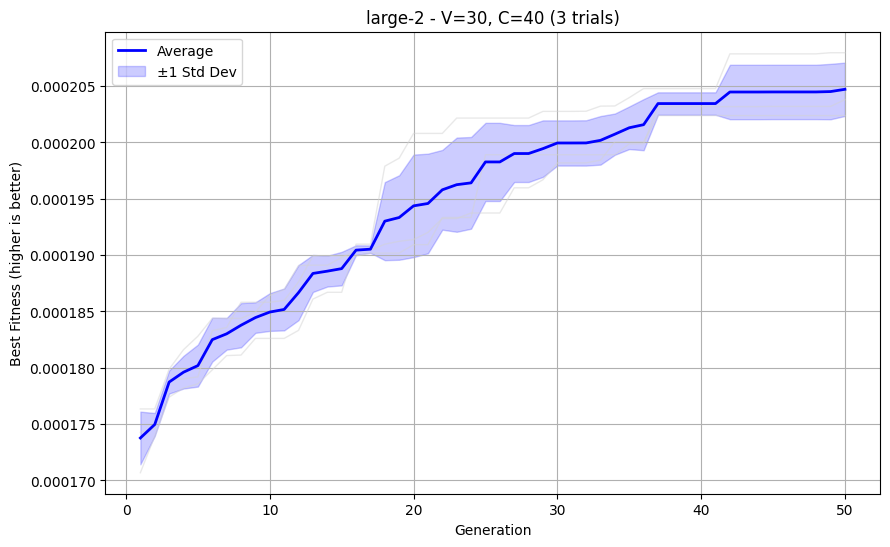

  Best final fitness: 0.000208
  Worst final fitness: 0.000202
  Average final fitness: 0.000205 ± 0.000002


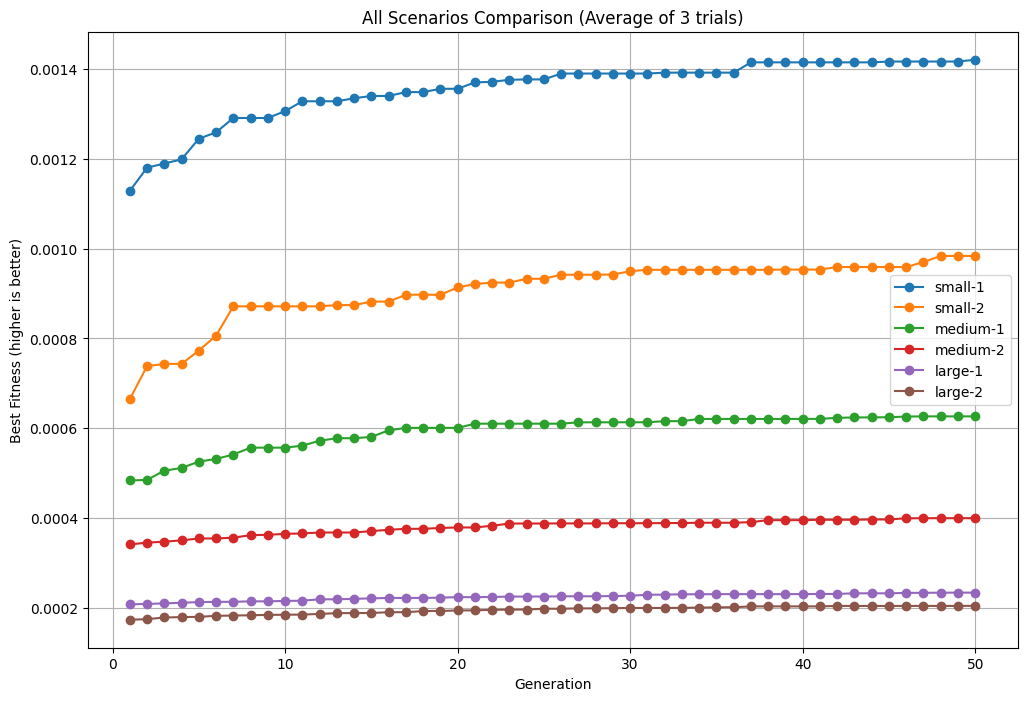


=== SUMMARY (3 trials per scenario) ===
Scenario    | Vehicles | Customers | Best      | Worst     | Average   | Std Dev
------------|----------|-----------|-----------|-----------|-----------|----------
small-1     |        3 |        12 |  0.001439 |  0.001408 |  0.001420 | 0.000014
small-2     |        7 |        18 |  0.001047 |  0.000915 |  0.000984 | 0.000054
medium-1    |       11 |        20 |  0.000633 |  0.000623 |  0.000626 | 0.000005
medium-2    |       15 |        28 |  0.000406 |  0.000397 |  0.000400 | 0.000004
large-1     |       26 |        30 |  0.000240 |  0.000231 |  0.000234 | 0.000004
large-2     |       30 |        40 |  0.000208 |  0.000202 |  0.000205 | 0.000002


In [4]:
# Run all 6 scenarios with multiple trials and plot statistics
import numpy as np  # **ADDED** - add this import at the top if not already there

scenarios = make_scenarios(seed=42)
all_results = {}
num_trials = 3  # 

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario['id']}")
    print(f"  Vehicles: {scenario['num_vehicles']}, Customers: {scenario['num_customers']}")
    
    # Apply the scenario
    applay_scenario(scenario)
    
    # **ADDED** - Run multiple trials
    trial_results = []
    final_fitnesses = []
    
    for trial in range(num_trials):
        print(f"  Trial {trial + 1}/{num_trials}...")
        best_fitness_per_gen = genetic_algorithm_with_tracking()
        trial_results.append(best_fitness_per_gen)
        final_fitnesses.append(best_fitness_per_gen[-1])
    
    # **ADDED** - Calculate statistics
    best_final = max(final_fitnesses)
    worst_final = min(final_fitnesses)
    avg_final = np.mean(final_fitnesses)
    std_final = np.std(final_fitnesses)
    
    all_results[scenario['id']] = {
        'trials': trial_results,
        'final_fitnesses': final_fitnesses,
        'best': best_final,
        'worst': worst_final,
        'avg': avg_final,
        'std': std_final
    }
    
    # **MODIFIED** - Plot all trials with statistics
    plt.figure(figsize=(10, 6))
    
    # Plot all individual trials in light gray
    for i, trial_data in enumerate(trial_results):
        plt.plot(range(1, generations+1), trial_data, color='lightgray', alpha=0.5, linewidth=1)
    
    # Plot average across trials
    avg_fitness_per_gen = np.mean(trial_results, axis=0)
    std_fitness_per_gen = np.std(trial_results, axis=0)
    
    plt.plot(range(1, generations+1), avg_fitness_per_gen, color='blue', linewidth=2, label='Average')
    plt.fill_between(range(1, generations+1), 
                     avg_fitness_per_gen - std_fitness_per_gen,
                     avg_fitness_per_gen + std_fitness_per_gen,
                     alpha=0.2, color='blue', label='±1 Std Dev')
    
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness (higher is better)')
    plt.title(f'{scenario["id"]} - V={scenario["num_vehicles"]}, C={scenario["num_customers"]} ({num_trials} trials)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # **ADDED** - Print trial statistics
    print(f"  Best final fitness: {best_final:.6f}")
    print(f"  Worst final fitness: {worst_final:.6f}")
    print(f"  Average final fitness: {avg_final:.6f} ± {std_final:.6f}")

# **MODIFIED** - Summary comparison plot with error bars
plt.figure(figsize=(12, 8))
for scenario_id, results in all_results.items():
    avg_fitness_per_gen = np.mean(results['trials'], axis=0)
    plt.plot(range(1, generations+1), avg_fitness_per_gen, marker='o', label=scenario_id)

plt.xlabel('Generation')
plt.ylabel('Best Fitness (higher is better)')
plt.title(f'All Scenarios Comparison (Average of {num_trials} trials)')
plt.legend()
plt.grid(True)
plt.show()

# **MODIFIED** - Enhanced summary table
print(f"\n=== SUMMARY ({num_trials} trials per scenario) ===")
print("Scenario    | Vehicles | Customers | Best      | Worst     | Average   | Std Dev")
print("------------|----------|-----------|-----------|-----------|-----------|----------")
for scenario in scenarios:
    results = all_results[scenario['id']]
    print(f"{scenario['id']:11} | {scenario['num_vehicles']:8} | {scenario['num_customers']:9} | "
          f"{results['best']:9.6f} | {results['worst']:9.6f} | "
          f"{results['avg']:9.6f} | {results['std']:8.6f}")
    
